In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "EVChargingStationUsage.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "venkatsairo4899/ev-charging-station-usage-of-california-city",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df.head()

In [72]:
import pandas as pd
df = pd.read_csv('EVChargingStationUsage.csv')

In [73]:
duplicates = df[df.duplicated(keep=False)]
duplicates

df.drop_duplicates(inplace=True)
df.shape

(259411, 33)

In [74]:
df = df.drop(28636)
df = df.drop(28705)

In [75]:
df = df.dropna(subset=['Transaction Date (Pacific Time)'])

In [ ]:
##Use this to calculate the total number of ports per station 
print(df.groupby('Station Name')['Port Number'].unique())

In [ ]:
#Converting date columns to datetime objects
df['Start Date'] =  pd.to_datetime(df['Start Date'])
df['Start Date']


df['End Date'] = pd.to_datetime(df['End Date'], errors = 'coerce')
df['End Date'].isna()

df['Transaction Date (Pacific Time)'] = pd.to_datetime(df['Transaction Date (Pacific Time)'], errors = 'coerce')

#Using total duration + start time to fill missing values in End Date
bad_rows_index = df['End Date'].isna()
bad_rows = df[bad_rows_index]

df['Total Duration (hh:mm:ss)'] = pd.to_timedelta(df['Total Duration (hh:mm:ss)'])

bad_rows = df['End Date'].isna()
df.loc[bad_rows, 'End Date'] = df.loc[bad_rows, 'Start Date'] + df.loc[bad_rows, 'Total Duration (hh:mm:ss)']

bad_rows_corrected = df[bad_rows_index]
bad_rows_corrected

In [8]:
## Start Time and End Time are converted to UTC
def convert_time(date, time_zone):
    if time_zone == 'PDT':
        # Explicitly PDT - use DST interpretation
        return date.tz_localize('US/Pacific',
                               ambiguous=True,
                               nonexistent='shift_forward').tz_convert('UTC')
    elif time_zone == 'PST':
        # Explicitly PST - use standard time interpretation
        return date.tz_localize('US/Pacific',
                               ambiguous=False,
                               nonexistent='shift_forward').tz_convert('UTC')
    else:
        return date.tz_localize('UTC')

df['Start Date'] = df.apply(lambda x: convert_time(x['Start Date'], x['Start Time Zone']), axis=1)
df['End Date'] = df.apply(lambda x: convert_time(x['End Date'], x['End Time Zone']), axis=1)
df['Transaction Date (Pacific Time)'] = df.apply(lambda x: convert_time(x['Transaction Date (Pacific Time)'],x['End Time Zone']), axis =1 )


In [ ]:
#Dropping any charging sessions that were recorded as greater than 1 day long
long_sessions = df[(df['End Date'] - df['Start Date']) > pd.Timedelta(days=1)]
long_sessions

In [10]:
df = df.drop(long_sessions.index)

In [ ]:
#Dropping any charging sessions that have an inconcistency in Transaction Date and End Date greater than 1 day
diff = df['Transaction Date (Pacific Time)'] - df['End Date']
rows_with_large_diff = df[diff > pd.Timedelta(days=1)]
rows_with_large_diff

In [12]:
df = df.drop(rows_with_large_diff.index)

In [ ]:
#Calculating duration and chargning in minutes
df['Duration(mins)'] = df['Total Duration (hh:mm:ss)'].dt.total_seconds() / 60
df['Charging Time (hh:mm:ss)'] = pd.to_timedelta(df['Charging Time (hh:mm:ss)'])
df['Charging(mins)'] = df['Charging Time (hh:mm:ss)'].dt.total_seconds() / 60




In [ ]:
#Breaking down the Start Date column into day, month, hour
df['Start Day'] = df['Start Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Start Month'] = df['Start Date'].dt.month # Month as number (1-12)
df['End Day'] = df['End Date'].dt.dayofweek
df['End Month'] = df['End Date'].dt.month
df['Start Hour of Day'] = df['Start Date'].dt.hour
df['End Hour of Day'] = df['End Date'].dt.hour



In [ ]:
#Manually calculated number of ports per base station
station_counts = {
    'PALO ALTO CA / HAMILTON' : 4,
    'PALO ALTO CA / HIGH' : 8,
    'PALO ALTO CA / BRYANT' : 13,
    'PALO ALTO CA / MPL' : 6,
    'PALO ALTO CA / RINCONADA LIB': 6,
    'PALO ALTO CA / WEBSTER': 6,
    'PALO ALTO CA / TED THOMPSON' : 8,
    'PALO ALTO CA / CAMBRIDGE' : 10,
    'PALO ALTO CA / SHERMAN' : 19
}


print(station_counts)

{'PALO ALTO CA / HAMILTON': 4, 'PALO ALTO CA / HIGH': 8, 'PALO ALTO CA / BRYANT': 13, 'PALO ALTO CA / MPL': 6, 'PALO ALTO CA / RINCONADA LIB': 6, 'PALO ALTO CA / WEBSTER': 6, 'PALO ALTO CA / TED THOMPSON': 8, 'PALO ALTO CA / CAMBRIDGE': 10, 'PALO ALTO CA / SHERMAN': 19}


In [ ]:
#Marking down each sessions base station
pattern = re.compile(r'^(.+?)\s*#?\s*\d+\s*$')
df['Base Station'] = df['Station Name'].str.extract(pattern, expand=False)




In [ ]:
import numpy as np
#Calculating the utilization of each station at a certian time by: total ports in use/ total ports at a base station
def calculate_utilization_vectorized(df, station_counts):
    # Extract datetime components
    start_datetimes = df['Start Date'].values  
    end_datetimes = df['End Date'].values      
    stations = df['Base Station'].values

    # Extract numpy datetime64 arrays for vectorized operations
    start_np = start_datetimes.astype('datetime64[m]')  # minute precision
    end_np = end_datetimes.astype('datetime64[m]')

    # Initialize busy counts aka total number of ports in use
    busy_counts = np.zeros(len(df), dtype=int)

    # Vectorized comparison
    for i in range(len(df)):
        # Find sessions with matching station
        same_station_mask = (stations == stations[i])

        # Current minute to check
        current_minute = start_np[i]

        # Count overlaps for current minute
        busy_counts[i] = np.sum(
            (start_np[same_station_mask] <= current_minute) &
            (current_minute < end_np[same_station_mask])
        )

    # Assign results
    df['Busy'] = busy_counts
    df['Utilization'] = df['Busy'] / df['Base Station'].map(station_counts)

    return df

calculate_utilization_vectorized(df, station_counts)



In [ ]:
#Making sure no rows have a utilization greater than 1 
df[df['Utilization'] > 1]

In [ ]:
#Save this cleaned up dataframe, no duplicates, problematic sessions, utilization is included
df.to_csv('my_data3.csv')

In [2]:
import pandas as pd

Start of data preprocessing

In [3]:
df = pd.read_csv('my_data3.csv', index_col=0)

C:\Users\mingl\AppData\Local\Temp\ipykernel_26868\449308675.py:1: DtypeWarning: Columns (30,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('my_data3.csv', index_col=0)


In [4]:
df['Base Station'].value_counts()

Base Station
PALO ALTO CA / BRYANT           46940
PALO ALTO CA / HIGH             39575
PALO ALTO CA / HAMILTON         38517
PALO ALTO CA / WEBSTER          37423
PALO ALTO CA / CAMBRIDGE        32796
PALO ALTO CA / MPL              28232
PALO ALTO CA / RINCONADA LIB    18226
PALO ALTO CA / TED THOMPSON     16672
PALO ALTO CA / SHERMAN             39
Name: count, dtype: int64

In [ ]:
#Remove sherman as it only has 39 sessions
df = df[df['Base Station'] != 'PALO ALTO CA / SHERMAN']

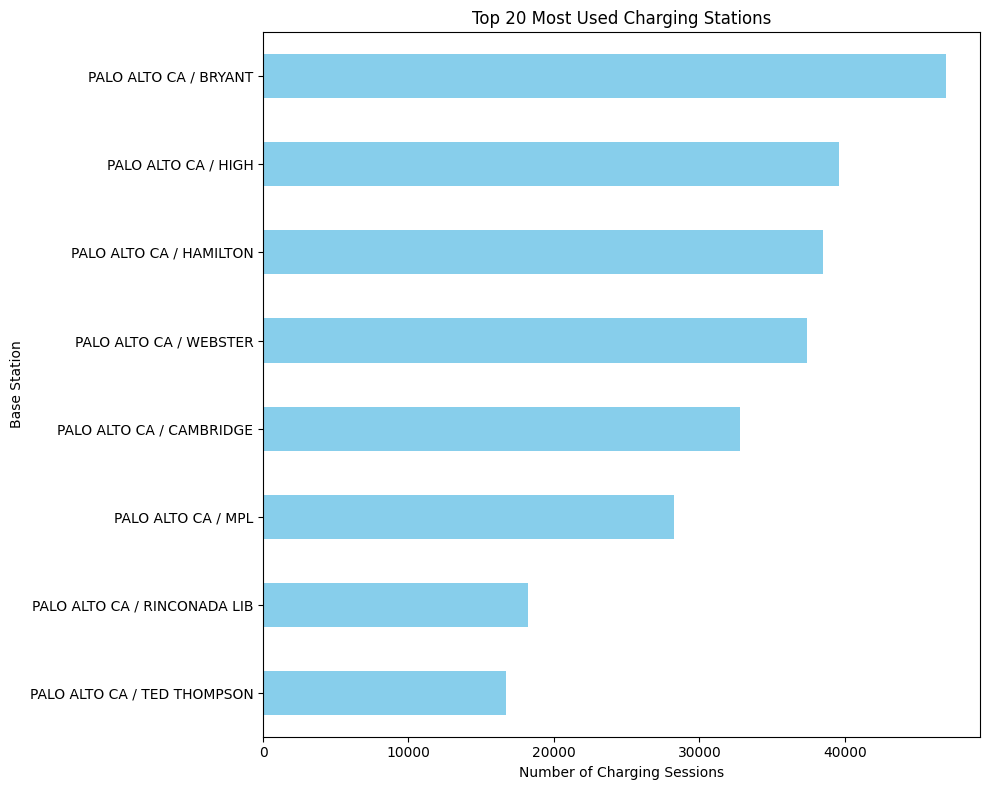

In [6]:
import matplotlib.pyplot as plt

station_counts = df['Base Station'].value_counts().head(20)  # Top 20 busiest
station_counts.plot(kind='barh', figsize=(10, 8), color='skyblue')
plt.xlabel("Number of Charging Sessions")
plt.ylabel("Base Station")
plt.title("Top 20 Most Used Charging Stations")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

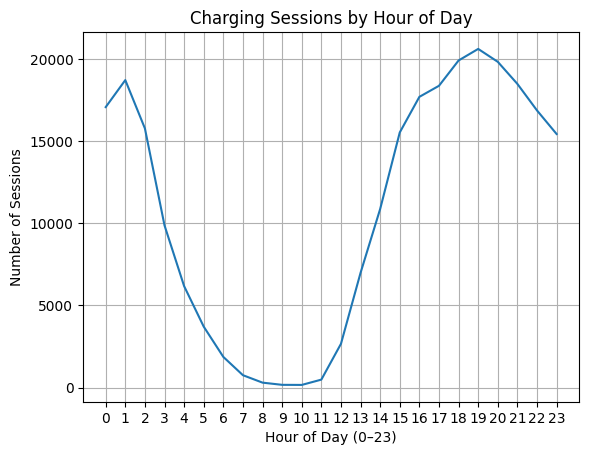

In [7]:
import seaborn as sns

hourly_usage = df.groupby('Start Hour of Day').size()
sns.lineplot(x=hourly_usage.index, y=hourly_usage.values)
plt.title("Charging Sessions by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Sessions")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

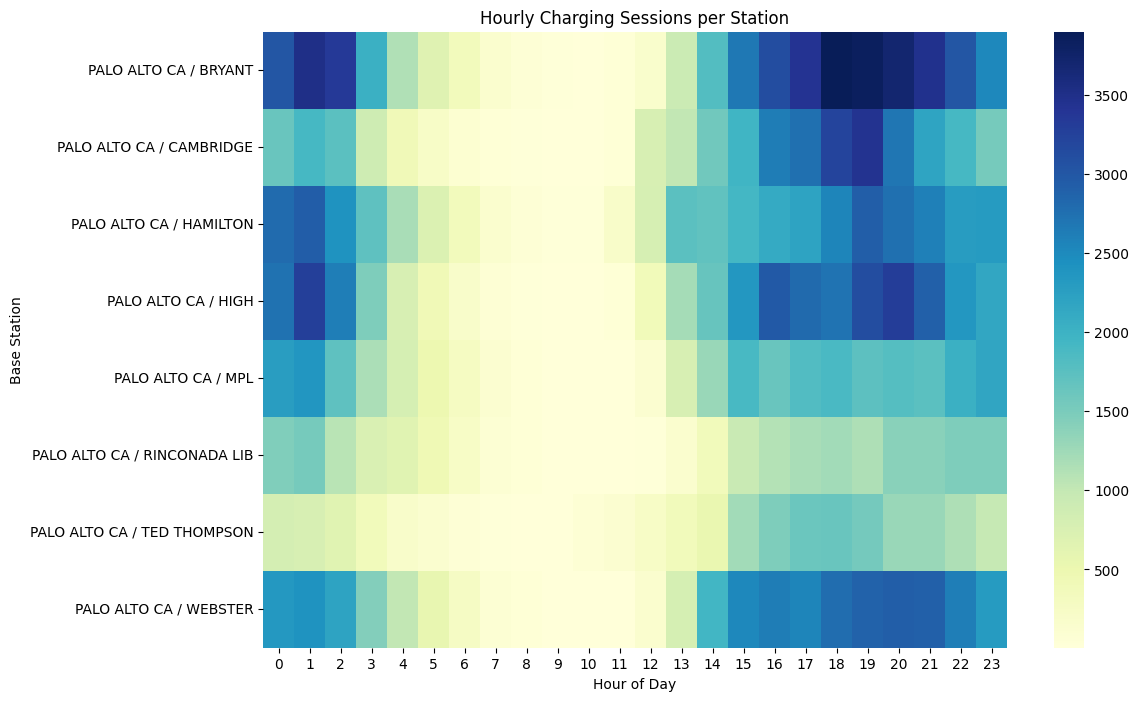

In [8]:
heat_df = df.groupby(['Base Station', 'Start Hour of Day']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heat_df, cmap="YlGnBu")
plt.title("Hourly Charging Sessions per Station")
plt.xlabel("Hour of Day")
plt.ylabel("Base Station")
plt.show()


In [9]:
top_stations = df['Base Station'].value_counts().head(10).index
heat_df = df[df['Base Station'].isin(top_stations)].groupby(['Base Station', 'Start Hour of Day']).size().unstack(fill_value=0)

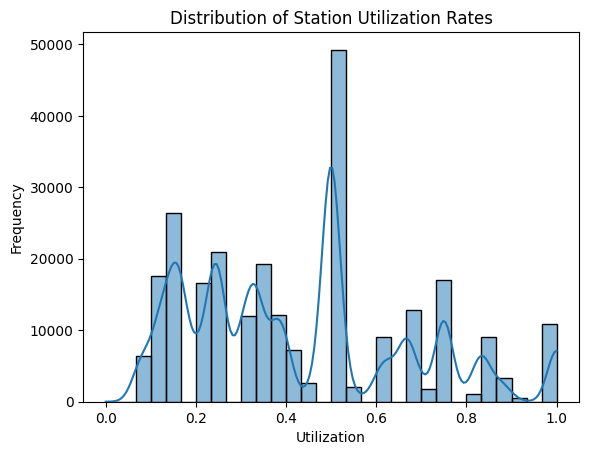

In [10]:
sns.histplot(df['Utilization'], bins=30, kde=True)
plt.title("Distribution of Station Utilization Rates")
plt.xlabel("Utilization")
plt.ylabel("Frequency")
plt.show()

In [11]:
df['Start Date'] =  pd.to_datetime(df['Start Date'])


In [12]:
df['Start Year'] = df['Start Date'].dt.year

In [13]:
df['Start Year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype=int32)

In [14]:
df.rename(columns={'Start Day': 'Start Day of Week'}, inplace=True)

In [15]:
df['Start Day of Month'] =df['Start Date'].dt.day

In [16]:
for col in df.columns:
    print(f"Column: {col}")

Column: Station Name
Column: MAC Address
Column: Org Name
Column: Start Date
Column: Start Time Zone
Column: End Date
Column: End Time Zone
Column: Transaction Date (Pacific Time)
Column: Total Duration (hh:mm:ss)
Column: Charging Time (hh:mm:ss)
Column: Energy (kWh)
Column: GHG Savings (kg)
Column: Gasoline Savings (gallons)
Column: Port Type
Column: Port Number
Column: Plug Type
Column: EVSE ID
Column: Address 1
Column: City
Column: State/Province
Column: Postal Code
Column: Country
Column: Latitude
Column: Longitude
Column: Currency
Column: Fee
Column: Ended By
Column: Plug In Event Id
Column: Driver Postal Code
Column: User ID
Column: County
Column: System S/N
Column: Model Number
Column: Duration(mins)
Column: Charging(mins)
Column: Start Day of Week
Column: Start Month
Column: End Day
Column: End Month
Column: Start Hour of Day
Column: End Hour of Day
Column: Base Station
Column: Busy
Column: Utilization
Column: Start Year
Column: Start Day of Month


In [17]:
#Load in a weather dataset taken from the open-meteo api, 
#that has the weather codes at each hour of our datasets timeframe
df_weather = pd.read_csv('open-meteo-37.43N122.07W11m (1).csv')

In [18]:
df_weather['time'] = pd.to_datetime(df_weather['time'])


In [19]:
#Round the Start Date column to the hour
df['datetime_hour'] = df['Start Date'].dt.floor('h')

In [20]:
df['datetime_hour'] = df['datetime_hour'].dt.tz_localize(None)


In [21]:
#Map the weather_code values to each session the EV dataset 
df = df.merge(
    df_weather[['time', 'weather_code (wmo code)']],
    left_on='datetime_hour',
    right_on='time',
    how='left'
)

In [22]:
#Manually correcting rows with missing weather codes
rows_to_update = [258414, 258415, 258416, 258417, 258418, 258419]
df.loc[rows_to_update, 'weather_code (wmo code)'] = 0

KeyError: "None of [Index([258414, 258415, 258416, 258417, 258418, 258419], dtype='int64')] are in the [index]"

In [23]:
df['weather_code (wmo code)'].unique()

array([ 0.,  2.,  3.,  1., 51., 61., 53., 55., 63., 65., nan])

In [24]:
#Dictionary that explains what each weather code means
wmo_weather_codes = {
    0:  "Clear sky",
    1:  "Mainly clear",
    2:  "Partly cloudy",
    3:  "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    56: "Light freezing drizzle",
    57: "Dense freezing drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    66: "Light freezing rain",
    67: "Heavy freezing rain",
    71: "Slight snow fall",
    73: "Moderate snow fall",
    75: "Heavy snow fall",
    77: "Snow grains",
    80: "Slight rain showers",
    81: "Moderate rain showers",
    82: "Violent rain showers",
    85: "Slight snow showers",
    86: "Heavy snow showers",
    95: "Thunderstorm",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}

In [25]:
df['weather_code (wmo code)'] = df['weather_code (wmo code)'].astype('Int64')

In [26]:
#Simplfying weather codes that dont have much difference
#In order to reduce noise in the model
def simplify_weather(code):
    if code in [0, 1]:
        return 0
    elif code in [2,3]:
        return 3
    elif code in [51,55,53]:
        return 51
    else:
        return code

In [27]:
df['weather_code (wmo code)'] = df['weather_code (wmo code)'].apply(simplify_weather)

In [28]:
df['weather_description'] = df['weather_code (wmo code)'].map(wmo_weather_codes)

In [29]:
import numpy as np
import math

In [30]:
#Create a feature called season 
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

df['Season'] = df['Start Month'].map(season_map)


In [31]:
#This way the model understands that the time and week are cylic
#This way instead of 12 and 1 being far way from each other mathetically
#In this representation with the sin and cos values, they are close to each other
df['hour_sin'] = np.sin(2 * math.pi * df['Start Hour of Day'] /24)
df['hour_cos'] = np.cos(2 * math.pi * df['Start Hour of Day']  / 24)
df['dow_sin' ] = np.sin(2 * math.pi * df['Start Day of Week']  / 7)
df['dow_cos' ] = np.cos(2 * math.pi * df['Start Day of Week']  / 7)

In [32]:
#Flag certain dates as holidays
import holidays
us_holidays = holidays.US()
df['is_holiday'] = df['datetime_hour'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)

In [33]:
#Flag dates that are the day before holidays
df['Day_before_holiday'] = df['datetime_hour'].dt.date.apply(
    lambda x: 1 if (x + pd.Timedelta(days=1)) in us_holidays else 0
)

In [34]:
#Sort the dataframe into base station then, chronological order
df = df.sort_values(by=['Base Station', 'datetime_hour'])
#Create a lag feature that has the value of the utilization 24 hours before
df['prev_day_util'] = df.groupby('Base Station')['Utilization'].shift(24)



In [35]:
df['prev_day_util'].isna().sum()

np.int64(192)

In [36]:
df = df.dropna(subset=['prev_day_util'])


In [37]:
# Time-aware split, this way we mimic real world deployment and train on historical data. Then test on future/current
cutoff_time = df['datetime_hour'].quantile(0.8)


train_df = df[df['datetime_hour'] <= cutoff_time].copy()
val_df   = df[df['datetime_hour'] > cutoff_time].copy()

In [38]:
#features going to be used to train base model
cols_to_keep = ['Base Station','dow_sin','dow_cos','hour_cos','hour_sin','Start Year','Start Month', 'Start Day of Month','Season','Day_before_holiday','is_holiday','weather_description','prev_day_util','Utilization']

In [39]:
X_train = train_df[cols_to_keep].drop('Utilization', axis=1)
y_train = train_df['Utilization']

X_val = val_df[cols_to_keep].drop('Utilization', axis=1)
y_val = val_df['Utilization']

In [40]:
#Convert categorical columns into category type for model
categorical_cols = ['Base Station','weather_description','Season']  
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [41]:
df_new = df[cols_to_keep].copy()

In [42]:
df_new.dtypes

Base Station            object
dow_sin                float64
dow_cos                float64
hour_cos               float64
hour_sin               float64
Start Year               int32
Start Month              int64
Start Day of Month       int32
Season                  object
Day_before_holiday       int64
is_holiday               int64
weather_description     object
prev_day_util          float64
Utilization            float64
dtype: object

In [43]:
X = df_new.drop('Utilization', axis=1)
y = df_new['Utilization']
for col in categorical_cols:
    X[col] = X[col].astype('category')

Train base LightGBM model


In [44]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [45]:

# Train LightGBM model and pass categorical_feature list
model = lgb.LGBMRegressor()

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    categorical_feature=categorical_cols
)

# Predict and evaluate
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
print(f"Validation RMSE: {rmse:.4f}")



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 206557, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.429185
Validation RMSE: 0.1933


In [46]:
#See what features are most important
importances = model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

                feature  importance
0          Base Station         643
5            Start Year         591
3              hour_cos         375
6           Start Month         290
4              hour_sin         281
1               dow_sin         245
12        prev_day_util         172
7    Start Day of Month         161
8                Season          82
2               dow_cos          79
10           is_holiday          39
9    Day_before_holiday          25
11  weather_description          17


In [47]:
#Caluculating Importance by gain rather than number of splits
gain_importances = model.booster_.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()

gain_importance_df = pd.DataFrame({
    'feature': feature_names,
    'gain_importance': gain_importances
}).sort_values(by='gain_importance', ascending=False)

print(gain_importance_df)

                feature  gain_importance
0          Base_Station     20461.678912
12        prev_day_util      9025.189583
5            Start_Year      7485.204238
3              hour_cos      2623.467603
4              hour_sin      1953.846756
1               dow_sin      1654.972269
6           Start_Month       874.641569
8                Season       206.109326
7    Start_Day_of_Month       166.914618
2               dow_cos       157.949198
10           is_holiday        93.668458
9    Day_before_holiday        22.317348
11  weather_description         7.096166


In [ ]:
#Grid search for best parameters
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import uniform, randint


# Time-aware CV
tscv = TimeSeriesSplit(n_splits=3)

# Define parameter distributions
param_dist = {
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 15),
    'min_child_samples': randint(10, 100),
    'feature_fraction': uniform(0.5, 0.5),
    'bagging_fraction': uniform(0.5, 0.5),
    'bagging_freq': randint(1, 10),
    'lambda_l1': uniform(0.0, 5.0),
    'lambda_l2': uniform(0.0, 5.0)
}

# Model
lgb_model = LGBMRegressor(n_estimators=1000, random_state=42)

# Random search
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=30,  # Number of random trials
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training set
random_search.fit(X_train, y_train, categorical_feature=categorical_cols)



In [ ]:
# Best model
best_model = random_search.best_estimator_

# Validation evaluation
y_pred = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {val_rmse:.4f}")

# Show best parameters
print("Best parameters:")
for k, v in random_search.best_params_.items():
    print(f"{k}: {v}")

[LightGBM] [Warning] feature_fraction is set=0.7486242529461927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7486242529461927
[LightGBM] [Warning] lambda_l1 is set=1.5043915490838482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5043915490838482
[LightGBM] [Warning] lambda_l2 is set=1.424202471887338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.424202471887338
[LightGBM] [Warning] bagging_fraction is set=0.6234380314193007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6234380314193007
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Validation RMSE: 0.1984
Best parameters:
bagging_fraction: 0.6234380314193007
bagging_freq: 7
feature_fraction: 0.7486242529461927
lambda_l1: 1.5043915490838482
lambda_l2: 1.424202471887338
learning_rate: 0.01737738947090656
max_depth: 3
min_child_samples: 11
num_leaves: 149


In [ ]:
#Model trained with best grid searched parameters
final_model = LGBMRegressor(
    **random_search.best_params_,
    n_estimators=1000,
    random_state=42
)

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    categorical_feature=categorical_cols
)


In [ ]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.1938


BUILD LSTM


In [ ]:
#One hot encoding of cateogrical columns for LSTM
X_train_enc = pd.get_dummies(X_train, columns=['Base Station', 'weather_description', 'Season'])

Preparing LSTM data...
Created 257997 sequences
Categorical shape: (257997, 24, 3)
Numerical shape: (257997, 24, 10)
Target shape: (257997,)

Training LSTM model...
Training samples: 206397
Testing samples: 51600

Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ station_input       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weather_input       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_input        │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 8)     │         72 │ station_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 24, 4)     │         28 │ weather_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 24, 3)     │         12 │ season_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 25)    │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ embedding[0][0],  │
│                     │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 50)    │     15,200 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 50)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 25)        │      7,600 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 25)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25)        │        650 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 25)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         26 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,588 (92.14 KB)

 Trainable params: 23,588 (92.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3225/3225 ━━━━━━━━━━━━━━━━━━━━ 92s 27ms/step - loss: 0.6234 - mae: 0.4898 - val_loss: 0.8950 - val_mae: 0.7615 - learning_rate: 0.0010
Epoch 2/50
3225/3225 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 0.5491 - mae: 0.4244 - val_loss: 0.8862 - val_mae: 0.7540 - learning_rate: 0.0010
Epoch 3/50
3225/3225 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.5375 - mae: 0.4137 - val_loss: 0.9561 - val_mae: 0.8171 - learning_rate: 0.0010
Epoch 4/50
3225/3225 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.5284 - mae: 0.4068 - val_loss: 0.8780 - val_mae: 0.7431 - learning_rate: 0.0010
Epoch 5/50
3225/3225 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.5252 - mae: 0.4045 - val_loss: 0.9199 - val_mae: 0.7829 - learning_rate: 0.0010
Epoch 6/50
3225/3225 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.5213 - mae: 0.4009 - val_loss: 0.8766 - val_mae: 0.7398 - learning_rate: 0.0010
Epoch 7/50
3225/3225 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.5166 - mae: 0.3968 - val_loss: 0.9219 - val_mae: 0.7823 - 

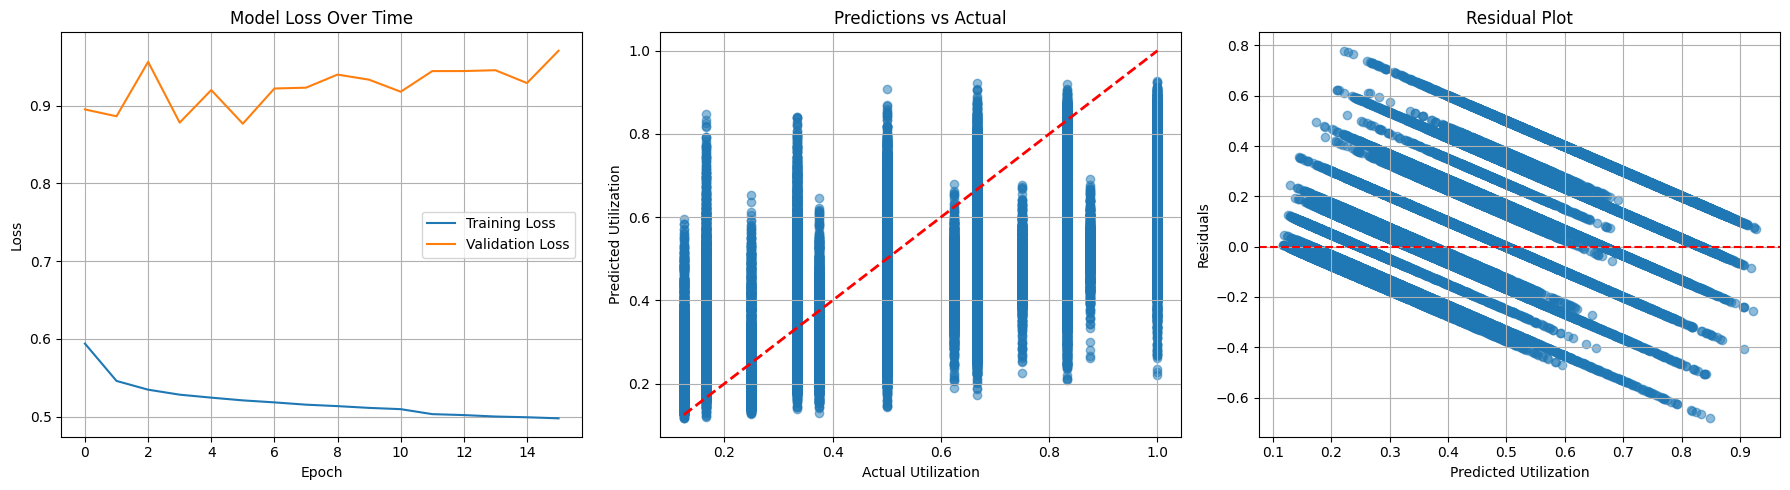


Model saved as 'ev_charging_lstm_model.h5'


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

df_new = df[cols_to_keep].copy()

def prepare_lstm_data(df, sequence_length=24, target_col='Utilization'):
    """
    Prepare sequences for LSTM, ensuring sequences don't cross station boundaries
    Uses embeddings instead of label encoding for categorical variables
    """
    # Ensure data is sorted by station and time
    df_sorted = df.sort_values(['Base Station', 'datetime_hour']).reset_index(drop=True)
    
    # Convert categorical to numeric IDs (for embeddings, not ordinal encoding)
    station_to_id = {station: idx for idx, station in enumerate(df_sorted['Base Station'].unique())}
    weather_to_id = {weather: idx for idx, weather in enumerate(df_sorted['weather_description'].unique())}
    season_to_id = {season: idx for idx, season in enumerate(df_sorted['Season'].unique())}
    
    df_encoded = df_sorted.copy()
    df_encoded['station_id'] = df_sorted['Base Station'].map(station_to_id)
    df_encoded['weather_id'] = df_sorted['weather_description'].map(weather_to_id)
    df_encoded['season_id'] = df_sorted['Season'].map(season_to_id)
    
    # Separate categorical and numerical features
    categorical_cols = ['station_id', 'weather_id', 'season_id']
    numerical_cols = [
        'dow_sin', 'dow_cos', 'hour_cos', 'hour_sin',
        'Start Year', 'Start Month', 'Start Day of Month',
        'Day_before_holiday', 'is_holiday', 'prev_day_util'
    ]
    
    # Scale only numerical features
    scaler_numerical = StandardScaler()
    scaler_target = StandardScaler()
    
    df_encoded[numerical_cols] = scaler_numerical.fit_transform(df_encoded[numerical_cols])
    df_encoded[[target_col]] = scaler_target.fit_transform(df_encoded[[target_col]])
    
    # Prepare sequences separately for categorical and numerical
    categorical_sequences = []
    numerical_sequences = []
    targets = []
    
    # Group by station to create sequences
    for station, group in df_encoded.groupby('Base Station'):
        cat_data = group[categorical_cols].values
        num_data = group[numerical_cols].values
        target_data = group[target_col].values
        
        # Create sequences within this station
        for i in range(sequence_length, len(group)):
            # Categorical sequence (same for all timesteps in sequence)
            cat_seq = cat_data[i-sequence_length:i]  # Shape: (seq_len, 3)
            num_seq = num_data[i-sequence_length:i]  # Shape: (seq_len, n_numerical)
            target = target_data[i]
            
            categorical_sequences.append(cat_seq)
            numerical_sequences.append(num_seq)
            targets.append(target)
    
    X_categorical = np.array(categorical_sequences)
    X_numerical = np.array(numerical_sequences)
    y = np.array(targets)
    
    print(f"Created {len(targets)} sequences")
    print(f"Categorical shape: {X_categorical.shape}")
    print(f"Numerical shape: {X_numerical.shape}")
    print(f"Target shape: {y.shape}")
    
    vocab_sizes = {
        'station': len(station_to_id),
        'weather': len(weather_to_id),
        'season': len(season_to_id)
    }
    
    return (X_categorical, X_numerical, y, scaler_numerical, scaler_target, 
            vocab_sizes, categorical_cols, numerical_cols)

def create_lstm_model(sequence_length, n_numerical_features, vocab_sizes, lstm_units=50):
    """
    Create LSTM model with embeddings for categorical features
    """
    from tensorflow.keras.layers import Input, Embedding, Concatenate, Reshape
    from tensorflow.keras import Model
    
    # Categorical inputs (for embeddings)
    station_input = Input(shape=(sequence_length,), name='station_input')
    weather_input = Input(shape=(sequence_length,), name='weather_input') 
    season_input = Input(shape=(sequence_length,), name='season_input')
    
    # Numerical input
    numerical_input = Input(shape=(sequence_length, n_numerical_features), name='numerical_input')
    
    # Embedding layers
    station_emb = Embedding(vocab_sizes['station'], 8)(station_input)  # 8-dim embedding
    weather_emb = Embedding(vocab_sizes['weather'], 4)(weather_input)  # 4-dim embedding  
    season_emb = Embedding(vocab_sizes['season'], 3)(season_input)     # 3-dim embedding
    
    # Concatenate all features
    all_features = Concatenate(axis=-1)([numerical_input, station_emb, weather_emb, season_emb])
    
    # LSTM layers
    lstm_out = LSTM(lstm_units, return_sequences=True)(all_features)
    lstm_out = Dropout(0.2)(lstm_out)
    lstm_out = LSTM(lstm_units//2, return_sequences=False)(lstm_out)
    lstm_out = Dropout(0.2)(lstm_out)
    
    # Dense layers
    dense_out = Dense(25, activation='relu')(lstm_out)
    dense_out = Dropout(0.1)(dense_out)
    output = Dense(1, activation='linear')(dense_out)
    
    # Create model
    model = Model(
        inputs=[numerical_input, station_input, weather_input, season_input], 
        outputs=output
    )
    
    # Custom RMSE loss
    def rmse_loss(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=rmse_loss,  # Using RMSE directly
        metrics=['mae']
    )
    
    return model

def train_lstm_model(X_categorical, X_numerical, y, sequence_length=24, test_size=0.2, epochs=100, vocab_sizes=None):
    """
    Train LSTM model with time-aware split and performance optimizations
    """
    # Time-aware split (last 20% for testing)
    split_idx = int(len(y) * (1 - test_size))
    
    X_cat_train, X_cat_test = X_categorical[:split_idx], X_categorical[split_idx:]
    X_num_train, X_num_test = X_numerical[:split_idx], X_numerical[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Training samples: {len(y_train)}")
    print(f"Testing samples: {len(y_test)}")
    
    # Create model
    n_numerical_features = X_numerical.shape[2]
    model = create_lstm_model(sequence_length, n_numerical_features, vocab_sizes)
    
    print("\nModel Architecture:")
    model.summary()
    
    # Enhanced callbacks for faster training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,  # Reduced from 15
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # Reduced from 10
        min_lr=1e-7,
        verbose=1
    )
    
    # Prepare inputs as list for functional model
    X_train_list = [X_num_train, X_cat_train[:,:,0], X_cat_train[:,:,1], X_cat_train[:,:,2]]
    X_test_list = [X_num_test, X_cat_test[:,:,0], X_cat_test[:,:,1], X_cat_test[:,:,2]]
    
    # Train model with larger batch size for speed
    history = model.fit(
        X_train_list, y_train,
        batch_size=64,  # Increased from 32 for speed
        epochs=epochs,
        validation_data=(X_test_list, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, history, X_train_list, X_test_list, y_train, y_test

def evaluate_model(model, X_test_list, y_test, scaler_target):
    """
    Evaluate the LSTM model
    """
    # Predictions (X_test_list for functional model)
    y_pred_scaled = model.predict(X_test_list)
    
    # Inverse transform to get actual scale
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_actual = scaler_target.inverse_transform(y_pred_scaled).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test_actual - y_pred_actual))
    
    print(f"\nModel Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    
    return y_test_actual, y_pred_actual, rmse

def plot_results(history, y_test_actual, y_pred_actual):
    """
    Plot training history and predictions
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Training history
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss Over Time')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Predictions vs Actual
    axes[1].scatter(y_test_actual, y_pred_actual, alpha=0.5)
    axes[1].plot([y_test_actual.min(), y_test_actual.max()], 
                 [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
    axes[1].set_xlabel('Actual Utilization')
    axes[1].set_ylabel('Predicted Utilization')
    axes[1].set_title('Predictions vs Actual')
    axes[1].grid(True)
    
    # Residuals
    residuals = y_test_actual - y_pred_actual
    axes[2].scatter(y_pred_actual, residuals, alpha=0.5)
    axes[2].axhline(y=0, color='r', linestyle='--')
    axes[2].set_xlabel('Predicted Utilization')
    axes[2].set_ylabel('Residuals')
    axes[2].set_title('Residual Plot')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load your data (assuming df_new is already available)
    # df_new should have all the columns you mentioned plus datetime_hour
    
    print("Preparing LSTM data...")
    (X_categorical, X_numerical, y, scaler_numerical, scaler_target, 
     vocab_sizes, categorical_cols, numerical_cols) = prepare_lstm_data(
        df_new, sequence_length=24
    )
    
    print("\nTraining LSTM model...")
    model, history, X_train_list, X_test_list, y_train, y_test = train_lstm_model(
        X_categorical, X_numerical, y, 
        sequence_length=24, epochs=50, vocab_sizes=vocab_sizes
    )
    
    print("\nEvaluating model...")
    y_test_actual, y_pred_actual, rmse = evaluate_model(model, X_test_list, y_test, scaler_target)
    
    print("\nPlotting results...")
    plot_results(history, y_test_actual, y_pred_actual)
    
    # Save model if needed
    model.save('ev_charging_lstm_model.h5')
    print("\nModel saved as 'ev_charging_lstm_model.h5'")

In [ ]:
# Assuming your cleaned data is in df (from your notebook)
df_new = df[cols_to_keep].copy()

# Make sure you have the datetime_hour column for sorting
df_new['datetime_hour'] = df['datetime_hour']

# Run the LSTM pipeline
X, y, scaler_features, scaler_target, le_station, le_weather, le_season, feature_cols = prepare_lstm_data(
    df_new, sequence_length=24
)

model, history, X_train, X_test, y_train, y_test = train_lstm_model(X, y)

Back to LightGBM

In [49]:
print(df.columns.tolist())

['Station Name', 'MAC Address', 'Org Name', 'Start Date', 'Start Time Zone', 'End Date', 'End Time Zone', 'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type', 'EVSE ID', 'Address 1', 'City', 'State/Province', 'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County', 'System S/N', 'Model Number', 'Duration(mins)', 'Charging(mins)', 'Start Day of Week', 'Start Month', 'End Day', 'End Month', 'Start Hour of Day', 'End Hour of Day', 'Base Station', 'Busy', 'Utilization', 'Start Year', 'Start Day of Month', 'datetime_hour', 'time', 'weather_code (wmo code)', 'weather_description', 'Season', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_holiday', 'Day_before_holiday', 'prev_day_util']


In [50]:
#Adding more detailed features
for lag_hours in [1, 2, 3, 6, 12, 24, 48, 168]:  # 1h, 2h, 3h, 6h, 12h, 1day, 2day, 1week
    # Create basic lag feature
    df[f'util_lag_{lag_hours}h'] = df.groupby('Base Station')['Utilization'].shift(lag_hours)
    
    # Seasonal fill for missing values
    # This fills missing lag values with the same hour from the earliest available day
    mask = df[f'util_lag_{lag_hours}h'].isna()
    if mask.any():
        # Create a helper to find seasonal replacement values
        def seasonal_fill(group):
            lag_col = f'util_lag_{lag_hours}h'
            util_col = 'Utilization'
            
            # Get the missing indices
            missing_mask = group[lag_col].isna()
            
            if missing_mask.any():
                # For each missing value, find the same hour of day from later data
                for idx in group[missing_mask].index:
                    current_time = group.loc[idx, 'datetime_hour']  # Assuming you have a datetime column
                    hour_of_day = current_time.hour
                    day_of_week = current_time.dayofweek
                    
                    # Look for the same hour and day of week in future data (within reasonable range)
                    future_data = group[group.index > idx].copy()
                    
                    if len(future_data) > 0:
                        # First try: exact same hour and day of week
                        same_pattern = future_data[
                            (future_data['datetime_hour'].dt.hour == hour_of_day) & 
                            (future_data['datetime_hour'].dt.dayofweek == day_of_week)
                        ]
                        
                        if len(same_pattern) > 0:
                            # Use the first matching pattern
                            group.loc[idx, lag_col] = same_pattern.iloc[0][util_col]
                        else:
                            # Fallback: same hour of day (any day of week)
                            same_hour = future_data[future_data['datetime_hour'].dt.hour == hour_of_day]
                            if len(same_hour) > 0:
                                group.loc[idx, lag_col] = same_hour.iloc[0][util_col]
                            else:
                                # Last fallback: use mean of first available week
                                first_week = future_data.head(min(168, len(future_data)))  # 168 hours = 1 week
                                if len(first_week) > 0:
                                    group.loc[idx, lag_col] = first_week[util_col].mean()
            
            return group
        
        # Apply seasonal fill by base station
        df = df.groupby('Base Station').apply(seasonal_fill).reset_index(drop=True)

# Rolling statistics (capture trends and volatility)
for window in [6, 12, 24, 168]:  # 6h, 12h, 1day, 1week
    print(f"Creating rolling features for {window}h window...")
    
    # Calculate rolling statistics and shift by 1 hour in one step
    df[f'util_rolling_mean_{window}h'] = df.groupby('Base Station')['Utilization'].rolling(window, min_periods=1).mean().reset_index(0, drop=True).groupby(df['Base Station']).shift(1)
    df[f'util_rolling_std_{window}h'] = df.groupby('Base Station')['Utilization'].rolling(window, min_periods=1).std().reset_index(0, drop=True).groupby(df['Base Station']).shift(1)
    df[f'util_rolling_max_{window}h'] = df.groupby('Base Station')['Utilization'].rolling(window, min_periods=1).max().reset_index(0, drop=True).groupby(df['Base Station']).shift(1)
    df[f'util_rolling_min_{window}h'] = df.groupby('Base Station')['Utilization'].rolling(window, min_periods=1).min().reset_index(0, drop=True).groupby(df['Base Station']).shift(1)
# Optional: Check how many values were filled
for lag_hours in [1, 2, 3, 6, 12, 24, 48, 168]:
    filled_count = df[f'util_lag_{lag_hours}h'].isna().sum()
    print(f"Lag {lag_hours}h: {filled_count} remaining missing values")



C:\Users\mingl\AppData\Local\Temp\ipykernel_26868\4278032767.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Base Station').apply(seasonal_fill).reset_index(drop=True)
C:\Users\mingl\AppData\Local\Temp\ipykernel_26868\4278032767.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Base Station').apply(seasonal_fill).reset_index(drop=True)
C:\Users\mingl\AppData\Local\Temp\ipyker

Creating rolling features for 6h window...
Creating rolling features for 12h window...
Creating rolling features for 24h window...
Creating rolling features for 168h window...
Lag 1h: 0 remaining missing values
Lag 2h: 0 remaining missing values
Lag 3h: 0 remaining missing values
Lag 6h: 0 remaining missing values
Lag 12h: 0 remaining missing values
Lag 24h: 0 remaining missing values
Lag 48h: 0 remaining missing values
Lag 168h: 0 remaining missing values


In [51]:
#Final features to train on
df_subset = df[['Start Day of Week', 'Start Month',  'Start Hour of Day',  'Base Station', 
        'Utilization', 'Start Year', 'Start Day of Month', 
        'datetime_hour', 'weather_description', 'Season', 'hour_sin', 
        'hour_cos', 'dow_sin', 'dow_cos', 'is_holiday', 
        'Day_before_holiday', 'util_lag_1h', 
        'util_lag_2h', 'util_lag_3h', 'util_lag_6h', 'util_lag_12h', 
        'util_lag_24h', 'util_lag_48h', 'util_lag_168h', 'util_rolling_mean_6h', 
        'util_rolling_std_6h','util_rolling_max_6h', 'util_rolling_min_6h' ,'util_rolling_mean_12h',
        'util_rolling_std_12h','util_rolling_max_12h','util_rolling_min_12h', 'util_rolling_mean_24h',
          'util_rolling_std_24h', 'util_rolling_min_24h','util_rolling_max_24h','util_rolling_mean_168h','util_rolling_max_168h','util_rolling_min_168h', 'util_rolling_std_168h']].copy()

In [52]:
df_subset.dtypes.count()

np.int64(40)

In [53]:
df_subset.isna().sum()

Start Day of Week          0
Start Month                0
Start Hour of Day          0
Base Station               0
Utilization                0
Start Year                 0
Start Day of Month         0
datetime_hour              0
weather_description        5
Season                     0
hour_sin                   0
hour_cos                   0
dow_sin                    0
dow_cos                    0
is_holiday                 0
Day_before_holiday         0
util_lag_1h                0
util_lag_2h                0
util_lag_3h                0
util_lag_6h                0
util_lag_12h               0
util_lag_24h               0
util_lag_48h               0
util_lag_168h              0
util_rolling_mean_6h       8
util_rolling_std_6h       16
util_rolling_max_6h        8
util_rolling_min_6h        8
util_rolling_mean_12h      8
util_rolling_std_12h      16
util_rolling_max_12h       8
util_rolling_min_12h       8
util_rolling_mean_24h      8
util_rolling_std_24h      16
util_rolling_m

In [54]:
df_subset.dropna(inplace=True)

In [55]:
df_subset.dtypes

Start Day of Week                  int64
Start Month                        int64
Start Hour of Day                  int64
Base Station                      object
Utilization                      float64
Start Year                         int32
Start Day of Month                 int32
datetime_hour             datetime64[ns]
weather_description               object
Season                            object
hour_sin                         float64
hour_cos                         float64
dow_sin                          float64
dow_cos                          float64
is_holiday                         int64
Day_before_holiday                 int64
util_lag_1h                      float64
util_lag_2h                      float64
util_lag_3h                      float64
util_lag_6h                      float64
util_lag_12h                     float64
util_lag_24h                     float64
util_lag_48h                     float64
util_lag_168h                    float64
util_rolling_mea

In [56]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [57]:
warnings.filterwarnings('ignore')
# ============================================================================
# DATA PREPROCESSING
# ============================================================================
print("Starting data preprocessing...")

# 1. Sort dataframe chronologically (by datetime only, not by base station)
print("Sorting data chronologically...")
df_subset = df_subset.sort_values('datetime_hour').reset_index(drop=True)
print(f"Data sorted by datetime_hour. Shape: {df_subset.shape}")

# Verify time range and station distribution
print(f"Time range: {df_subset['datetime_hour'].min()} to {df_subset['datetime_hour'].max()}")
print(f"Stations in first 100 records: {df_subset['Base Station'].head(100).nunique()}")
print(f"Stations in last 100 records: {df_subset['Base Station'].tail(100).nunique()}")
print(f"Total unique stations: {df_subset['Base Station'].nunique()}")

# 2. Handle categorical columns
print("\nProcessing categorical columns...")
categorical_cols = ['weather_description','Season', 'Base Station']
label_encoders = {}

# Identify categorical columns (object or category dtype, excluding datetime)
for col in df_subset.columns:
    if df_subset[col].dtype in ['object', 'category'] and col not in ['datetime_hour', 'Utilization']:
        categorical_cols.append(col)

print(f"Found categorical columns: {categorical_cols}")

# Encode categorical columns
for col in categorical_cols:
    print(f"  Encoding {col}...")
    le = LabelEncoder()
    df_subset[col] = le.fit_transform(df_subset[col].astype(str))
    label_encoders[col] = le
    print(f"    {col}: {len(le.classes_)} unique categories")

# 3. Define feature columns (now including Base Station and other categoricals)
exclude_cols = ['Utilization', 'datetime_hour']  # Only exclude target and datetime
feature_cols = [col for col in df_subset.columns if col not in exclude_cols]

print(f"\nTotal features: {len(feature_cols)}")
print(f"Feature categories:")
lag_features = [col for col in feature_cols if 'lag_' in col]
rolling_features = [col for col in feature_cols if 'rolling_' in col]
categorical_feature_cols = [col for col in feature_cols if col in categorical_cols]
other_features = [col for col in feature_cols if col not in lag_features + rolling_features + categorical_feature_cols]

print(f"  - Lag features: {len(lag_features)}")
print(f"  - Rolling features: {len(rolling_features)}")
print(f"  - Categorical features: {len(categorical_feature_cols)} {categorical_feature_cols}")
print(f"  - Other features: {len(other_features)}")

# Show Base Station distribution
if 'Base Station' in feature_cols:
    print(f"\nBase Station distribution:")
    station_counts = df_subset['Base Station'].value_counts()
    print(f"  Number of stations: {len(station_counts)}")
    print(f"  Records per station - Min: {station_counts.min()}, Max: {station_counts.max()}, Mean: {station_counts.mean():.1f}")


Starting data preprocessing...
Sorting data chronologically...
Data sorted by datetime_hour. Shape: (258168, 40)
Time range: 2011-08-06 03:00:00 to 2020-12-31 23:00:00
Stations in first 100 records: 1
Stations in last 100 records: 6
Total unique stations: 8

Processing categorical columns...
Found categorical columns: ['weather_description', 'Season', 'Base Station', 'Base Station', 'weather_description', 'Season']
  Encoding weather_description...
    weather_description: 6 unique categories
  Encoding Season...
    Season: 4 unique categories
  Encoding Base Station...
    Base Station: 8 unique categories
  Encoding Base Station...
    Base Station: 8 unique categories
  Encoding weather_description...
    weather_description: 6 unique categories
  Encoding Season...
    Season: 4 unique categories

Total features: 38
Feature categories:
  - Lag features: 8
  - Rolling features: 16
  - Categorical features: 3 ['Base Station', 'weather_description', 'Season']
  - Other features: 11



In [58]:
warnings.filterwarnings('ignore')
# ============================================================================
# DATA SPLITTING (Time Series Aware)
# ============================================================================
print(f"\n" + "="*50)
print("DATA SPLITTING")
print("="*50)

# Prepare data
X = df_subset[feature_cols].copy()
y = df_subset['Utilization'].copy()

# Handle any remaining missing values
print(f"Missing values per feature:")
missing_counts = X.isnull().sum()
missing_features = missing_counts[missing_counts > 0]
if len(missing_features) > 0:
    print(missing_features)
    # Fill remaining missing values (if any)
    X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    print("Missing values filled.")
else:
    print("No missing values found.")

# Time series split (important for time series data)
# Use last 20% for testing, and cross-validate on the rest
test_size = int(0.2 * len(df_subset))
X_temp, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_temp, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# Further split temp data for training and validation
val_size = int(0.2 * len(X_temp))
X_train, X_val = X_temp.iloc[:-val_size], X_temp.iloc[-val_size:]
y_train, y_val = y_temp.iloc[:-val_size], y_temp.iloc[-val_size:]

print(f"\nData splits:")
print(f"  Training: {len(X_train)} samples")
print(f"  Validation: {len(X_val)} samples") 
print(f"  Test: {len(X_test)} samples")

# LightGBM parameters optimized for time series regression
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 50,  # Increased from 31
    'learning_rate': 0.03,  # Decreased for more iterations
    'feature_fraction': 0.9,  # Increased
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 10,  # Decreased
    'min_child_weight': 0.001,
    'reg_alpha': 0.05,  # Reduced
    'reg_lambda': 0.05,  # Reduced
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# Create LightGBM datasets with categorical feature specification
print("Creating LightGBM datasets...")
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feature_cols)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature=categorical_feature_cols)



DATA SPLITTING
Missing values per feature:
No missing values found.

Data splits:
  Training: 165228 samples
  Validation: 41307 samples
  Test: 51633 samples
Creating LightGBM datasets...


In [59]:
warnings.filterwarnings('ignore')
# ============================================================================
# MODEL TRAINING
# ============================================================================
print(f"\n" + "="*50)
print("MODEL TRAINING")
print("="*50)
print("Training LightGBM model...")
model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)


MODEL TRAINING
Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.113056	val's rmse: 0.13641
[200]	train's rmse: 0.109077	val's rmse: 0.131695
[300]	train's rmse: 0.107252	val's rmse: 0.130342
[400]	train's rmse: 0.105885	val's rmse: 0.130062
[500]	train's rmse: 0.104587	val's rmse: 0.129817
[600]	train's rmse: 0.103559	val's rmse: 0.129791
Early stopping, best iteration is:
[587]	train's rmse: 0.103703	val's rmse: 0.129781



MODEL EVALUATION

Training Metrics:
  RMSE: 0.1037
  MAE: 0.0786
  R²: 0.8271

Validation Metrics:
  RMSE: 0.1298
  MAE: 0.1008
  R²: 0.6815

Test Metrics:
  RMSE: 0.1265
  MAE: 0.0993
  R²: 0.7120


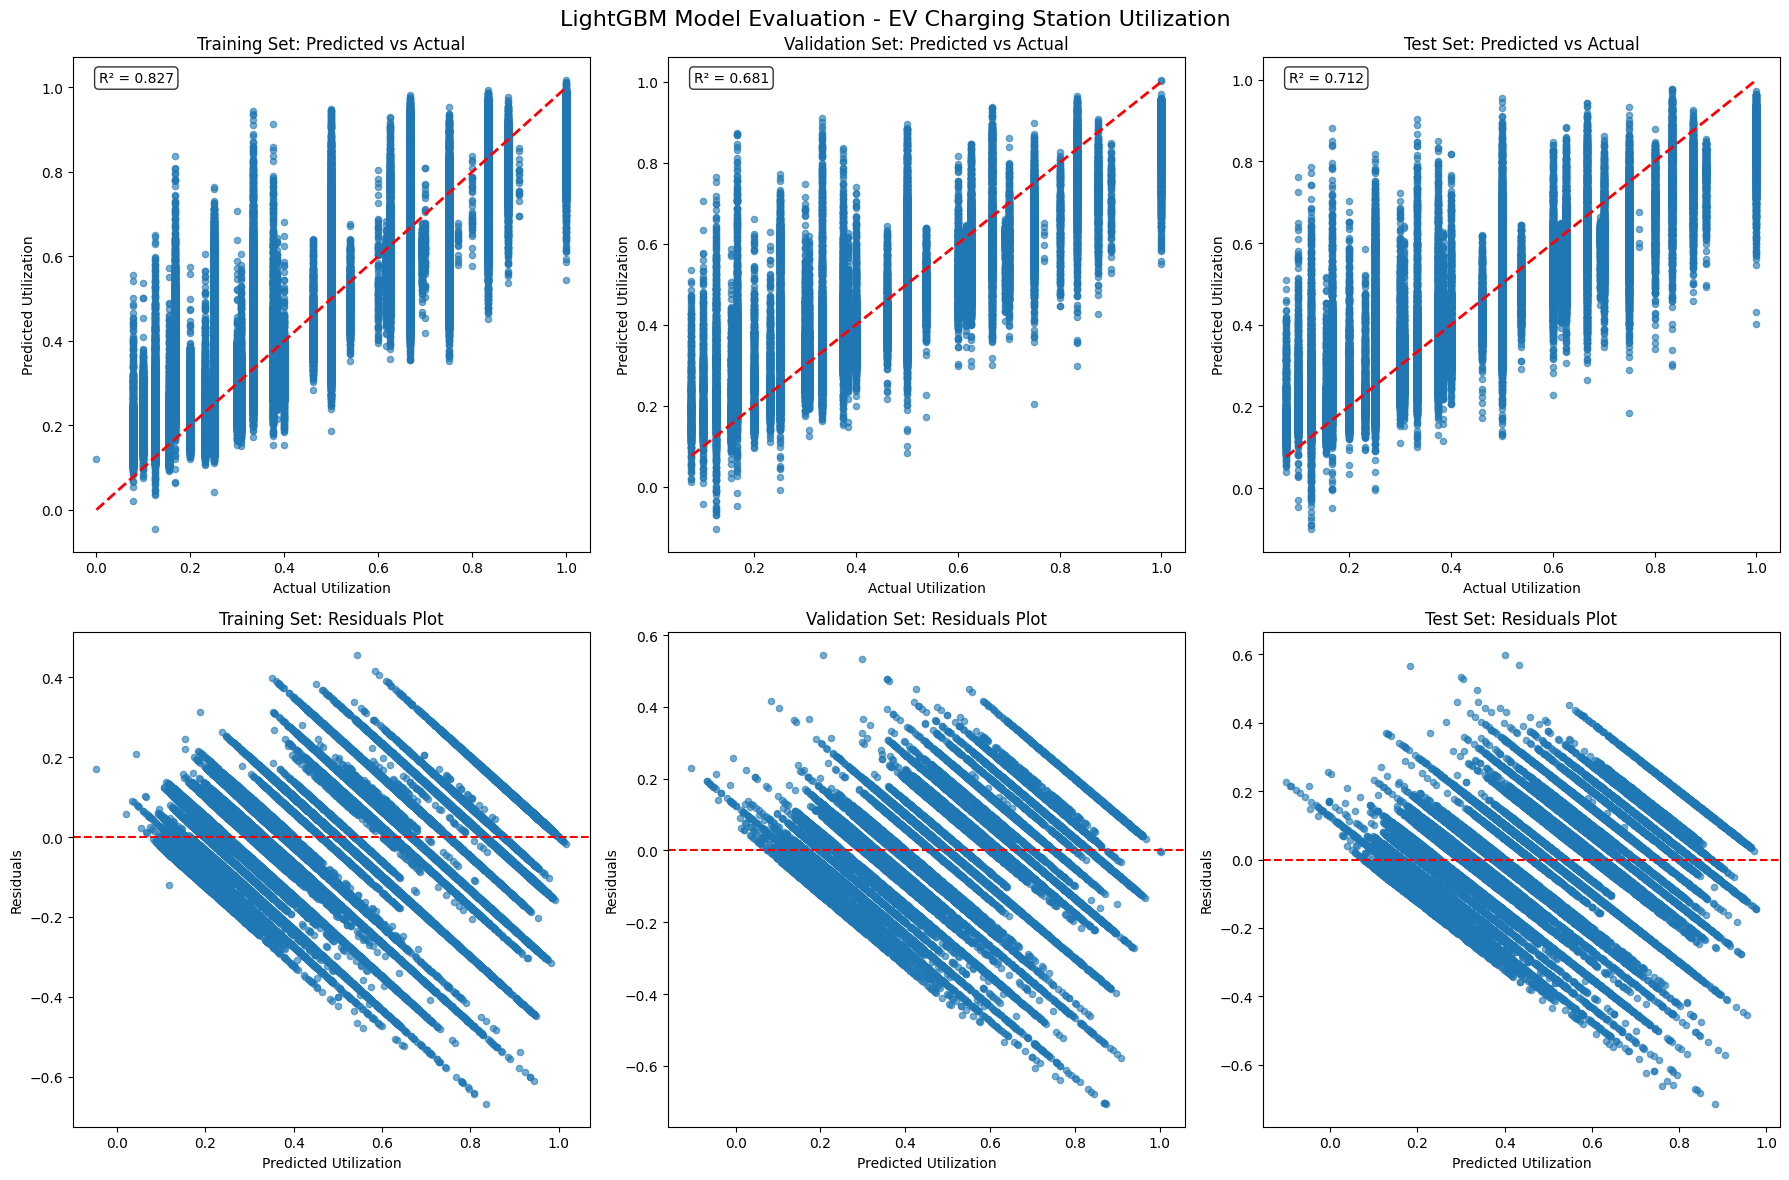

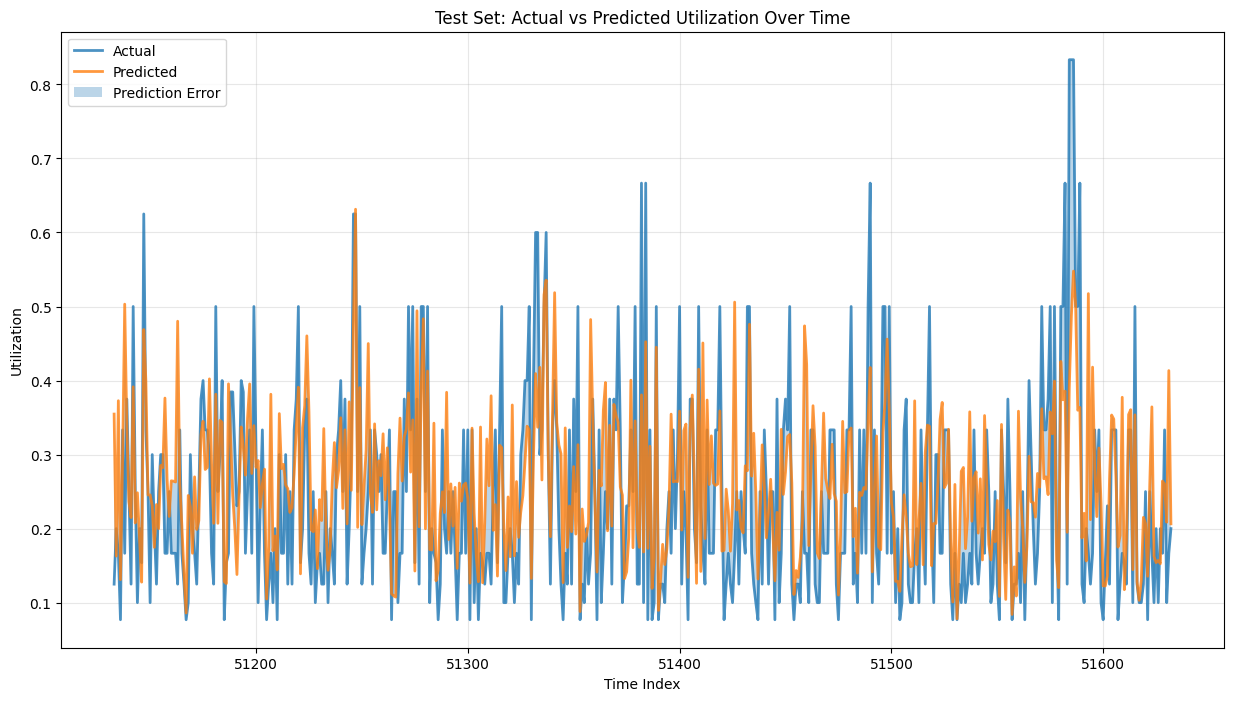


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
               feature   importance  split_importance
           util_lag_1h 86975.350964              1854
util_rolling_mean_168h  6460.382021              2104
   util_rolling_max_6h  5303.792400               171
 util_rolling_mean_24h  4534.294411              1283
              hour_cos  1713.133395              1610
              hour_sin  1385.487934              1399
 util_rolling_min_168h  1249.193110               301
     Start Hour of Day  1221.716502              1624
          Base Station   885.574418               834
  util_rolling_mean_6h   860.231621               950
 util_rolling_std_168h   649.902521              1864
     Start Day of Week   609.603327               982
           util_lag_2h   569.388325               637
            Start Year   347.916504               779
   util_rolling_std_6h   281.380920              1264
 util_rolling_mean_12h   265.521724              1046
  util_rolling_std_1

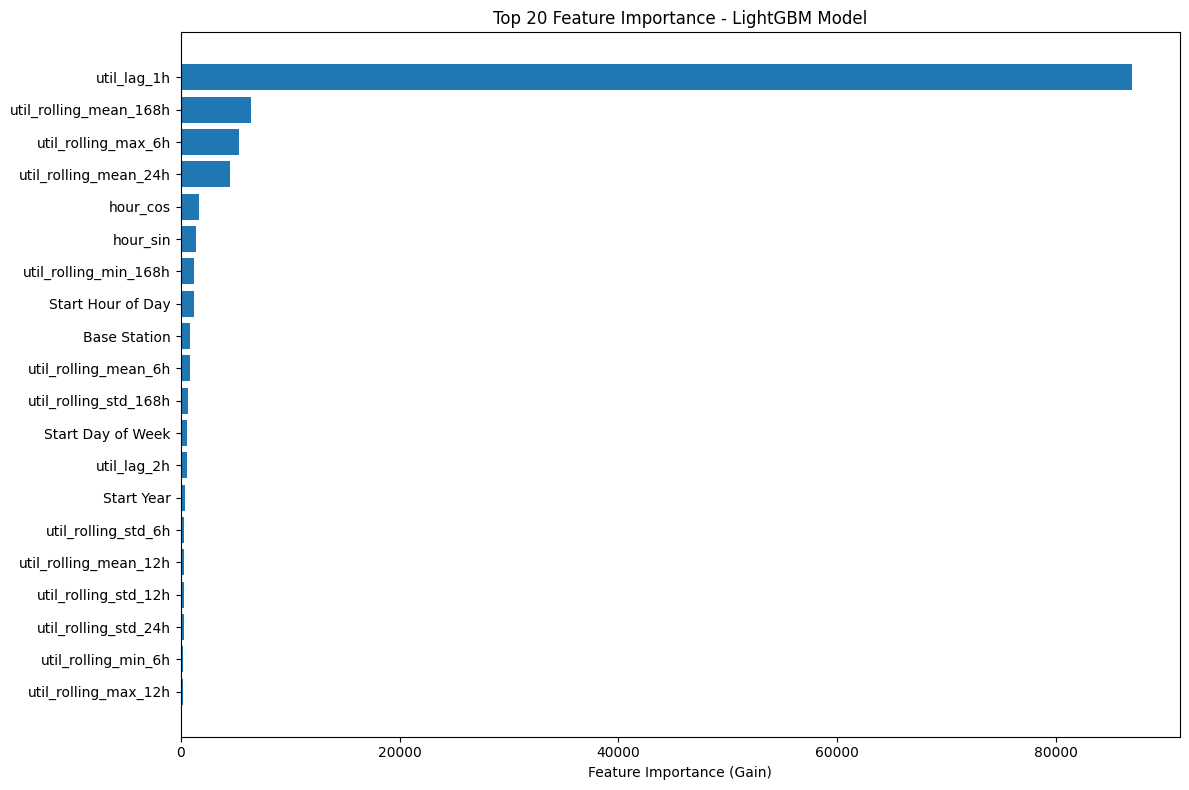


MODEL SUMMARY
Best iteration: 587
Total features used: 38
Final Test RMSE: 0.1265
Final Test MAE: 0.0993
Final Test R²: 0.7120

Model Complexity:
  Number of trees: 587
  Number of leaves per tree: 50
  Learning rate: 0.03
  Categorical features: 3
  Categorical feature names: ['Base Station', 'weather_description', 'Season']

Dataset Info:
  Total records: 258,168
  Date range: 2011-08-06 03:00:00 to 2020-12-31 23:00:00
  Unique base stations: 8
  Features used: 38


In [60]:
# ============================================================================
# MODEL EVALUATION
# ============================================================================
print(f"\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    
    return rmse, mae, r2

# Calculate and display metrics
train_rmse, train_mae, train_r2 = calculate_metrics(y_train, y_train_pred, "Training")
val_rmse, val_mae, val_r2 = calculate_metrics(y_val, y_val_pred, "Validation")
test_rmse, test_mae, test_r2 = calculate_metrics(y_test, y_test_pred, "Test")

# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('LightGBM Model Evaluation - EV Charging Station Utilization', fontsize=16)

# 1. Predicted vs Actual scatter plots
datasets = [
    (y_train, y_train_pred, "Training", axes[0, 0]),
    (y_val, y_val_pred, "Validation", axes[0, 1]), 
    (y_test, y_test_pred, "Test", axes[0, 2])
]

for y_true, y_pred, name, ax in datasets:
    ax.scatter(y_true, y_pred, alpha=0.6, s=20)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    ax.set_xlabel('Actual Utilization')
    ax.set_ylabel('Predicted Utilization')
    ax.set_title(f'{name} Set: Predicted vs Actual')
    
    # Add R² to plot
    r2 = r2_score(y_true, y_pred)
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Residuals plots
residuals_train = y_train - y_train_pred
residuals_val = y_val - y_val_pred
residuals_test = y_test - y_test_pred

residual_datasets = [
    (y_train_pred, residuals_train, "Training", axes[1, 0]),
    (y_val_pred, residuals_val, "Validation", axes[1, 1]),
    (y_test_pred, residuals_test, "Test", axes[1, 2])
]

for y_pred, residuals, name, ax in residual_datasets:
    ax.scatter(y_pred, residuals, alpha=0.6, s=20)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel('Predicted Utilization')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{name} Set: Residuals Plot')

plt.tight_layout()
plt.show()

# 3. Time series plot (showing predictions vs actual for test set)
plt.figure(figsize=(15, 8))

# For visualization, let's show a subset of the test data
viz_size = min(500, len(y_test))  # Show last 500 points or all if less
test_indices = range(len(y_test) - viz_size, len(y_test))

plt.plot(test_indices, y_test.iloc[-viz_size:], label='Actual', linewidth=2, alpha=0.8)
plt.plot(test_indices, y_test_pred[-viz_size:], label='Predicted', linewidth=2, alpha=0.8)
plt.fill_between(test_indices, 
                 y_test.iloc[-viz_size:], y_test_pred[-viz_size:], 
                 alpha=0.3, label='Prediction Error')

plt.xlabel('Time Index')
plt.ylabel('Utilization')
plt.title('Test Set: Actual vs Predicted Utilization Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Feature Importance Analysis
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain'),
    'split_importance': model.feature_importance(importance_type='split')
}).sort_values('importance', ascending=False)

# Display top features
print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Feature importance by category
print(f"\nFeature Importance by Category:")
categories = {
    'Categorical Features (Base Station, etc.)': categorical_feature_cols,
    'Lag Features': lag_features,
    'Rolling Statistics': rolling_features, 
    'Other Features': other_features
}

for category, features in categories.items():
    if features:
        cat_importance = importance_df[importance_df['feature'].isin(features)]['importance'].sum()
        cat_avg_importance = importance_df[importance_df['feature'].isin(features)]['importance'].mean()
        cat_count = len([f for f in features if f in importance_df['feature'].values])
        print(f"  {category}: Total={cat_importance:.1f}, Average={cat_avg_importance:.1f}, Count={cat_count}")

# Show Base Station importance specifically
if 'Base Station' in importance_df['feature'].values:
    base_station_importance = importance_df[importance_df['feature'] == 'Base Station']['importance'].iloc[0]
    base_station_rank = importance_df[importance_df['feature'] == 'Base Station'].index[0] + 1
    print(f"\nBase Station Feature:")
    print(f"  Importance: {base_station_importance:.1f}")
    print(f"  Rank: #{base_station_rank} out of {len(feature_cols)} features")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 20 Feature Importance - LightGBM Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Summary
print(f"\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print(f"Best iteration: {model.best_iteration}")
print(f"Total features used: {len(feature_cols)}")
print(f"Final Test RMSE: {test_rmse:.4f}")
print(f"Final Test MAE: {test_mae:.4f}")
print(f"Final Test R²: {test_r2:.4f}")

# Model complexity and categorical info
print(f"\nModel Complexity:")
print(f"  Number of trees: {model.best_iteration}")
print(f"  Number of leaves per tree: {lgb_params['num_leaves']}")
print(f"  Learning rate: {lgb_params['learning_rate']}")
print(f"  Categorical features: {len(categorical_feature_cols)}")
if categorical_feature_cols:
    print(f"  Categorical feature names: {categorical_feature_cols}")

# Data info
print(f"\nDataset Info:")
print(f"  Total records: {len(df_subset):,}")
print(f"  Date range: {df_subset['datetime_hour'].min()} to {df_subset['datetime_hour'].max()}")
print(f"  Unique base stations: {df_subset['Base Station'].nunique()}")
print(f"  Features used: {len(feature_cols)}")